In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.regularizers import l1
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import regularizers

In [2]:
# Load Data
data = pd.read_csv("wellington_data.csv")

In [3]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d')
data['Date'] = data['Date'].apply(lambda x: x.value) # Total Nanoseconds from 1970-01-01 00:00:00 UTC to That Datetime 

In [4]:
# Data Preprocessing

#data['Date'] = pd.to_datetime(data['Date'])
#data['Month'] = data['Date'].dt.month
#data['DayOfWeek'] = data['Date'].dt.dayofweek
#data['IsWeekend'] = data['DayOfWeek'].apply(lambda x: 1 if x > 4 else 0)

for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = pd.to_numeric(data[col], errors='coerce')
data = data.fillna(data.median())

#  Define a Function to Handle Outliers
def replace_outliers(data, n_std=3):
    for column in data.select_dtypes(include=np.number).columns:
        mean = data[column].mean()
        std = data[column].std()
        
        # Calculate Threshold for Outliers
        upper_bound = mean + n_std * std
        lower_bound = mean - n_std * std

        # Replace Outliers 
        data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])
        data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
    
    return data

# Identify Features and Target Variable
features = data.drop(columns=['Daily Average PM10 (ug/m3)', 'Daily Average PM2.5 (ug/m3)'])
target = data[['Daily Average PM10 (ug/m3)', 'Daily Average PM2.5 (ug/m3)']]

# Normalization
# Create a MinMaxScaler Instance for Input Features
input_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = input_scaler.fit_transform(features)

# Create Another MinMaxScaler Instance for the Target Variable 
output_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = output_scaler.fit_transform(target)

# Save Both Scaler Instances Separately
import joblib
joblib.dump(input_scaler, 'Wellington_input_scaler.pkl')
joblib.dump(output_scaler, 'Wellington_output_scaler.pkl')

# Split Data
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42, shuffle=False)
# Adjust Data Shape for CNN and LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Dropout, MaxPooling1D
# Calculate the Number of Features
n_features = features.shape[1]
feature_names = features.columns

# Build LSTM Model
#model = Sequential([
#    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'),
#    Dropout(0.2),
#    LSTM(100, return_sequences=False, activation='relu'),
#    Dropout(0.2),
 #   Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
 #   Dense(2)  
#])

# Build a CNN model, using fully connected layers
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(2)
])

#model = Sequential()
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.2))
# LSTM Layer
#model.add(LSTM(100, activation='relu', return_sequences=False))
#model.add(Dropout(0.2))

# Output Layer
#model.add(Dense(2))
# Compile the Model
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Set Early Stopping to Avoid Overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the Model
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=256, 
    verbose=2, 
    shuffle=False, 
    validation_split=0.1, 
    callbacks=[early_stopping]
)

Epoch 1/50
5/5 - 0s - loss: 0.3280 - val_loss: 0.1475 - 451ms/epoch - 90ms/step
Epoch 2/50
5/5 - 0s - loss: 0.1466 - val_loss: 0.0530 - 19ms/epoch - 4ms/step
Epoch 3/50
5/5 - 0s - loss: 0.0743 - val_loss: 0.0177 - 18ms/epoch - 4ms/step
Epoch 4/50
5/5 - 0s - loss: 0.0555 - val_loss: 0.0136 - 19ms/epoch - 4ms/step
Epoch 5/50
5/5 - 0s - loss: 0.0544 - val_loss: 0.0143 - 19ms/epoch - 4ms/step
Epoch 6/50
5/5 - 0s - loss: 0.0587 - val_loss: 0.0121 - 19ms/epoch - 4ms/step
Epoch 7/50
5/5 - 0s - loss: 0.0513 - val_loss: 0.0111 - 20ms/epoch - 4ms/step
Epoch 8/50
5/5 - 0s - loss: 0.0465 - val_loss: 0.0124 - 19ms/epoch - 4ms/step
Epoch 9/50
5/5 - 0s - loss: 0.0444 - val_loss: 0.0137 - 18ms/epoch - 4ms/step
Epoch 10/50
5/5 - 0s - loss: 0.0450 - val_loss: 0.0132 - 19ms/epoch - 4ms/step
Epoch 11/50
5/5 - 0s - loss: 0.0438 - val_loss: 0.0119 - 19ms/epoch - 4ms/step
Epoch 12/50
5/5 - 0s - loss: 0.0433 - val_loss: 0.0112 - 20ms/epoch - 4ms/step
Epoch 13/50
5/5 - 0s - loss: 0.0404 - val_loss: 0.0110 - 20

In [6]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

Test Loss: 0.01234412845224142


In [7]:
# Prediction
predictions = model.predict(X_test)

# Use the MinMaxScaler Instance of Output Data to Inverse Scale Predictions 
predictions_inversed = output_scaler.inverse_transform(predictions)

# Use the MinMaxScaler Instance of Output Data to Inverse Scale True Test Data
y_test_inversed = output_scaler.inverse_transform(y_test)

# Calculate Evaluation Metrics
mse = mean_squared_error(y_test_inversed, predictions_inversed)
mae = mean_absolute_error(y_test_inversed, predictions_inversed)
r2 = r2_score(y_test_inversed, predictions_inversed)

# Print Evaluation Metrics
print("Mean Squared Error (MSE): ", mse)
print("Mean Absolute Error (MAE): ", mae)
print("R² Score: ", r2)

10/10 [==============================] - 0s 575us/step
Mean Squared Error (MSE):  17.007743475960208
Mean Absolute Error (MAE):  2.9917813688170782
R² Score:  -0.2196125365902321


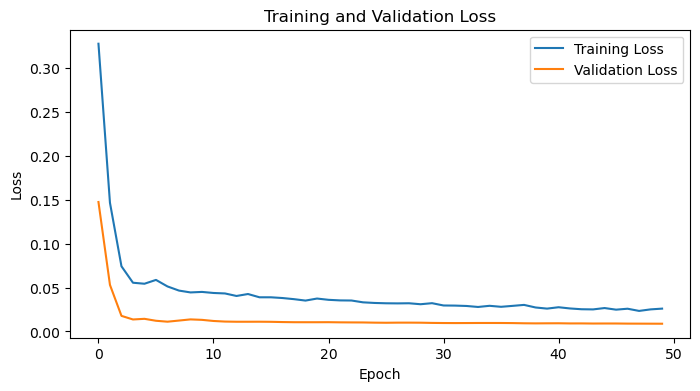

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


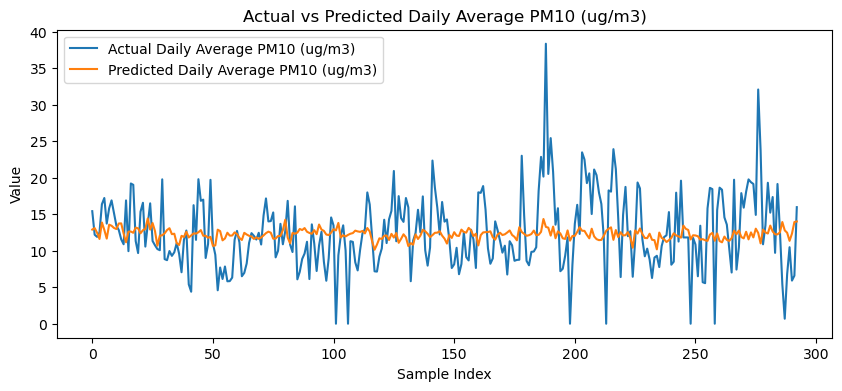

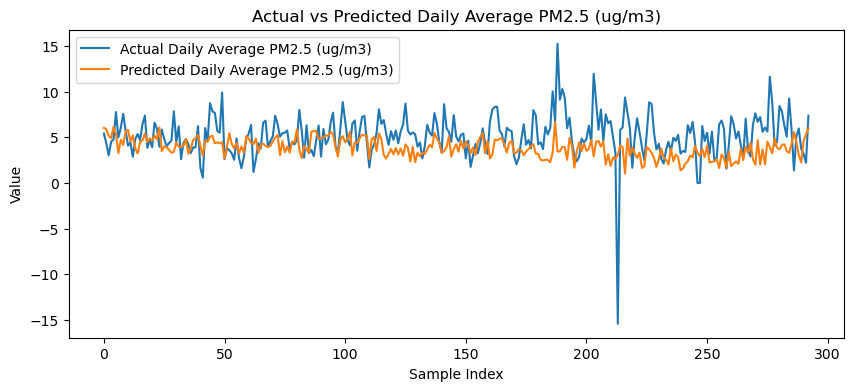

In [9]:
# Plot Predictions vs. Actual Values
target_labels = ['Daily Average PM10 (ug/m3)', 'Daily Average PM2.5 (ug/m3)']
for i in range(2):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inversed[:, i], label=f'Actual {target_labels[i]}')
    plt.plot(predictions_inversed[:, i], label=f'Predicted {target_labels[i]}')
    plt.title(f'Actual vs Predicted {target_labels[i]}')
    plt.ylabel('Value')
    plt.xlabel('Sample Index')
    plt.legend()
    plt.show()


In [10]:
# Save the Entire Model to an HDF5 File
model.save('/Users/yangyi/778/Wellington_model.h5')

/Users/yangyi/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
